# Object Recognition in the modern era
## (And how it differs from object detection)

Object recognition is the term used to refer to the procedure of identifying semantic content from visual data.  This is the process that you perform when I show you a picture, and you tell me what's in it:
<img src="what_am_i.jpg"/>
Object recognition in the context of *computer vision* is teaching an algorithm to identify what this thing is, usually from a finite set of possibilities.  Note that this is really different from everything that we've been doing up to this point.  We're no longer measuring a physical quantity, but rather asking the algorithm to summarize the contents of an image in order to reduce it to some meaningful statement about its content.  This is also much closer to what we usually think of as "artifical intelligence".  

Note that this task of object recognition is held in contrast to what is called "object detection".  In object detection, we seek to identify the location of an object of interest in an image: Where's Waldo is an example.  Note that these ideas overlap substantially, in the sense that object recognition procedures can be used as a subroutine in object detection, something we'll delve into at the end of this course.  For now, let's concern ourselves with the problem of object recognition.


## The methods
Solutions to this problem are substantially younger than, say, structure from motion.  Indeed, significant progress towards getting a computer to classify an image as 1 in 100 classes wasn't really made until the last decade (arguably two decades).  The reason for this is because this is the time period in which two essential technologies finally matured.  The first is in hardware, namely the availability of extremely powerful Graphical Processing Units (GPUs).  The second ingredient is algorithmic, and it has supplanted essentially every other algorithm used for object recognition (and nearly every other semantic computer vision task): the Convolutional Neural Network.

## CNNs
Many of you have taken Machine Learning, and so you've had an introduction to CNNs already.  **An excellent online resource can be found in the form of Andrew Ng's videos on this subject, found [here](https://youtu.be/ArPaAX_PhIs).  If you're new to CNNs, I suggest that you watch C4W1L01-C4W1L11.  If you've seen this stuff before, you can safely skip the first four lectures.**

First, we should think about what a neural network is, and at a conceptual level it is very simple: a neural network is a function that maps from an input (like an image) to an output (like a classification: hedgehog, rat, chicken, etc.).  It is a very general function, in the sense that it has many parameters that can be tuned in order to make the function behave how we want it to.  In order to tune these parameters, we show the neural network a large number of inputs, and their associated desired outputs (e.g. an image and an animal species), and adjust the parameters so that this mapping generally yields a correct results.  This is a process that you're almost certainly already seen before: regression.  

A schematic of a basic type of neural network called a multilayer perceptron looks like this:
<img src="nn.png" width=400/>
Lines represent so-called weights, the parameters that are adjusted in order to make the model behave as we wish.  At every layer of the network, these weights $\mathbf{W}$ multiply and then add the previous layer's output (along with a bias $\mathbf{b}$, and then the output is run through a so-called activation function $\sigma$, e.g.
$$
\mathbf{x}_{l+1} = \sigma(\mathbf{W}_l \mathbf{x}_l + \mathbf{b}_l).
$$
The activation function $\sigma$ can be many different things: a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), a [rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks), or the [Softmax function](https://en.wikipedia.org/wiki/Softmax_function), the choice of which depends upon the desired behavior of the neural network layer.  For the hidden layers in the middle of the neural network, the ReLU (rectified linear unit) is the standard choice nowadays.  Note that there can be many of these hidden layers between the network input and output.  For classification problems, the final layer is almost always Softmax, which is used to produce a probability for each of several potential classes.  

One way of applying neural networks to image data is to assume that all of the pixels in an image are input features in a multilayer perceptron.  However, there is a major difficulty with this approach.  In a normal image of size 480x480x3, there are 691200 inputs.  If we then have a hidden layer with a similar number of nodes (i.e. our neural network layer maps from an image back to a similarly sized image), then our matrix of weights is 691200x691200, which means our network already has around 500 billion parameters, which is kind of alot, and will require a commensurate amount of data to adequately constrain (just like we need at least two data points to constrain a univariate linear regression model, or 3 gcps to estimate camera pose, the number of required observations scales with the number of model parameters).  

A better idea for applying neural networks to images is to scan a small portion of the image at a time.  A CNN is a type of neural network that is designed to work with image data (or anything else where there are a large number of dimensionally ordered inputs, e.g. audio, gene sequences, etc.), and operates by sweeping a small window (often called a perceptive field) across the input, calculating a response at each position.  The essence of a CNN is right in the name (convolution), and this is something we've already explored in this course: convolution of an input image with a kernel to produce a so-called *feature map*. 

Earlier in the course, we designed kernels in order to produce the results that we wanted.  In particular, we developed a kernel to smooth/blur an image (the Gaussian kernel), a kernel to extract vertical edges (the Sobol-x operator), and one to extract horizontal edges (the Sobol-y operator).  For example, if we apply the Sobol-x operator to the hedgehog above, we get the following feature map

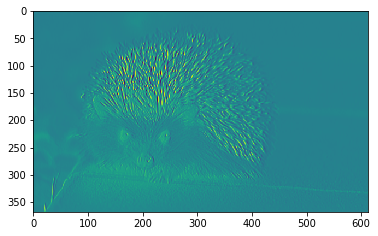

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssig

hedgehog = plt.imread('what_am_i.jpg')
hedgehog = hedgehog.mean(axis=2)

sobol_x = np.array([[-1,0,1],
                    [-2,0,1],
                    [-1,0,1]])

fmap_sobol_x = ssig.convolve2d(hedgehog,sobol_x,mode='valid')
plt.imshow(fmap_sobol_x)
plt.show()

In a convolutional network, we are taking many of these filters and applying them to an input, then running the result through a non-linear function called an *activation*, for example a sigmoid, or a rectified linear unit.  So, the first layer of a CNN might look like this, if we were using the three kernels mentioned above:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


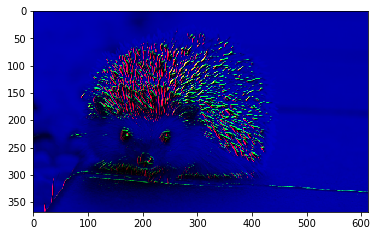

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssig

hedgehog = plt.imread('what_am_i.jpg')
hedgehog = hedgehog.mean(axis=2)/255.

def relu(X):
    return np.maximum(X,0)

sobol_x = 1.0*np.array([[-1,0,1],
                    [-2,0,1],
                    [-1,0,1]])

sobol_y = sobol_x.T

gauss = 1./8*np.array([[0,1,0],
                       [1,2,1],
                       [0,1,0]])

fmap_sobol_x = ssig.convolve2d(hedgehog,sobol_x,mode='valid')
fmap_sobol_y = ssig.convolve2d(hedgehog,sobol_y,mode='valid')
fmap_gauss = ssig.convolve2d(hedgehog,gauss,mode='valid')

y = relu(np.dstack((fmap_sobol_x,fmap_sobol_y,fmap_gauss)))

plt.imshow(y)
plt.show()

Displaying a false color image of the resulting feature maps, we can see that things like the hedghog quills are highlighted.  Perhaps this transformation of the input can help us in determining what this creature is?  There are few other animals which would yield such a pattern.  This is the fundamental utility of the convolutional part of the neural network: to non-linearly transform the inputs into something that is more easily interpreted as the object that it is.  

How is this a type of neural network?  In the case of a CNN, the coefficients of the kernels are tunable parameters, or weights.  Thus, if highlighting vertical lines in the image were to help the neural network correctly classify the image as a hedgehog, then perhaps it would learn some approximation to the Sobol-x kernel.  The *architecture* of a CNN typically looks sort of like this:
<img src="cnn.png" width=800/>
We take an input image, and convolve it with a bunch of learned kernels to produce a bunch of feature maps.  Optionally, we will then downsample these feature maps (a popular method is called max-pooling, where we downsample by grabbing the largest value in a region).  This resulting set of feature maps is essentially a new image, and we can repeat the process, convolving with a new set of kernels to achieve yet another feature map, which optionally downscale.  This process is repeated until the image is small enough that we can use its pixels as inputs to a normal multilayer perceptron neural network.  Thus the convolutional part of the neural network can be seen as a form of data reduction, where we sequentially highlight the most salient features of our image, keeping those and throwing away superfluous features until we can make a decision about what we're looking at based on those reduced features.

## Implementation of a CNN in Keras
In years past implementation of neural networks, particularly large and challenging ones like CNNs often are, was a substantial endeavour.  However, nowadays, with these things being utilized in all sorts of ways, there exists excellent software libraries that largely abstract away these difficulties.  One such library is called [Keras](https://keras.io/), which provides a convenient API for generating all sorts of neural networks, including convolutional ones.  It sits atop another excellent piece of software, called [Tensorflow](https://www.tensorflow.org/), which is a general framework for computation on graphs.  

**For our further exercises, you'll want to install tensorflow and keras on your computer.**  If possible, install it with GPU support, although this can be a difficult process: for more challenging computation, I will be providing you with SSH access to a machine with a large GPU that has these libraries installed already.  However, for our first simple examples that we will use here, it will not really be needed.

We begin by importing Keras into python


In [224]:
import keras

As a first example, we'll apply a neural network to the CIFAR-10 dataset, which contains 60000 32x32x3 images, each of which contains an object in one of 10 classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.  We seek to develop a neural network that can, given a new input image, successfully classify the image into one of these categories.  CIFAR-10 is a classic and highly standardized benchmark dataset for image recognition algorithms.  The images are also small enough to make for pretty fast and efficient model training.  It is included as part of the Keras package

In [225]:
import keras.datasets as kd

(x_train, y_train), (x_test, y_test) = kd.cifar10.load_data()
labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(x_train.shape)

(50000, 32, 32, 3)


Above we see that the numpy array x_train contains 50000 32x32x3 color images.  Let's plot a few.

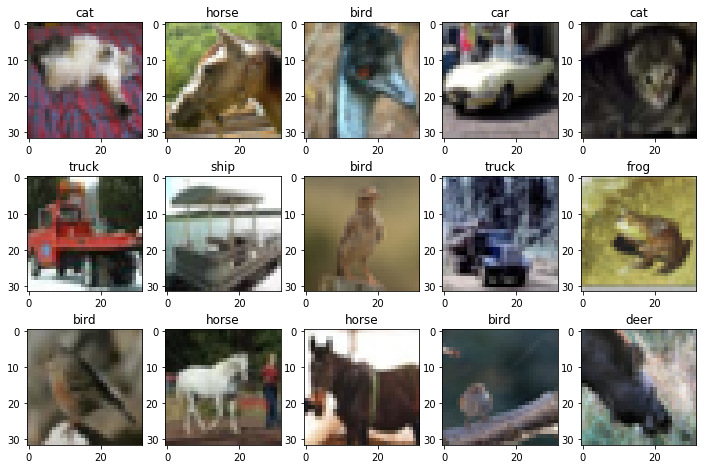

In [226]:
import matplotlib.pyplot as plt
import numpy as np
fig,axs = plt.subplots(nrows=3,ncols=5,figsize=(12,8))
for r in axs:
    for ax in r:
        idx = np.random.randint(0,50000)
        ax.imshow(x_train[idx])
        ax.set_title(labels[y_train[idx][0]])
        
plt.show()

These images are our input, while the label is our output.  While we can certainly work with the whole dataset, let's pare it down a bit so that our code runs faster:  in particular, let's see if we can solve a 3-class problem where we ask a neural network to discriminate between deer, ships, and cats.  We'll have to take a subset of our training and test data.


In [227]:
def take_subset_based_on_labels(X,y,indices_to_keep):
    boolean_mask = np.logical_or.reduce([y==i for i in indices_to_keep]).squeeze()
    for i,j in enumerate(indices_to_keep):
        y[y==j]=i
    return X[boolean_mask]/255.,y[boolean_mask]

new_labels = [labels[i] for i in [3,4,8]]
x_train,y_train = take_subset_based_on_labels(x_train,y_train,[3,4,8])
x_test,y_test = take_subset_based_on_labels(x_test,y_test,[3,4,8])

Currently, our labels are in the form of a vector of integers between 0 and 2, each indicating one of our three classes.  It is more convenient to work in the context of a *one-hot* matrix, i.e. a matrix with $m$ entries (one for each image) and $N$ columns, one for each class.  This is convenient because our neural network is actually going to output a probability of class membership for each one of these classes, yielding a matrix $m \times N$, which can be directly compare to our one hot matrix.  We can also view our class label matrix as the known probabilities of class membership, to which we will compare our predicted probabilities: in this case, exactly one class has a 100% chance of being the correct class. 

In [228]:
# Convert class vectors to binary class matrices.
N = len(new_labels)

y_train = keras.utils.to_categorical(y_train, N)
y_test = keras.utils.to_categorical(y_test, N)

In [229]:
print(y_train)

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


Now, with our training data in place, we can begin constructing a convolutional neural network.  Determining the shape of this network is more art than science: there are precious few theoretical results indicating what an optimal neural network *architecture* should be.  As such it's mostly a matter of experimentation to see what yields good results.

The container that holds the layers of our neural network is a sequential model (i.e. the information flows from the input to the the output).

In [230]:
import keras.models as km
model = km.Sequential()

Now we need to start adding layers to it.  The first layer that we add will be a convolutional layer.

In [231]:
import keras.layers as kl
conv_1 = kl.Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:])
model.add(conv_1)

Let's look at the syntax.  The first is the number of kernels that we are going to apply to the input image at this layer, in this case 32.  Each of these kernels will be also operate on the full color depth of the image.  The second argument specifies the width and height, so the size of each of the 32 kernels is 3x3x3.  Convolving these kernels with the input leads to 32 feature maps which are the same width and height as the input (because of the 'same' padding argument).  As such, the output of this layer is going to be a stack of 32 'bands' (sort of like R,G, and B), each the same size as the input bands.  Next we are going to apply an activation function to this output, which makes the mapping from the input to the feature maps *non-linear*.  Most modern networks use the ReLU activation.

In [232]:
act_1 = kl.Activation('relu')
model.add(act_1)

To speed up model optimization, we can Z-normalize the output of this layer, such that it has zero-mean and unit variance.  This helps to ensure that the magnitude of the parameters in different layers is similar.  This process is called *batch normalization*

In [233]:
bn_1 = kl.BatchNormalization()
model.add(bn_1)

Finally, we'll reduce the size of our (transformed) image input through a down-scaling operation.  Remember that we're trying to map from an image (lots of values) to a scalar, so we'll need to reduce the size somewhere along the way.  By downscaling, we reduce the size of the image, and also provide our function the opportunity to pick up  relevant features at different spatial scales, sort of like an image pyramid. 

The most popular mechanism for downscaling is called max-pooling, which is simply a max-filter over a neighborhood (here we'll use 2x2) followed by downsampling over that neighborhood.  It is implemented in keras as follows:

In [234]:
#mp_1 = kl.MaxPooling2D(pool_size=(2,2))
mp_1 = kl.Conv2D(32, kernel_size=(2, 2), strides=(2, 2))
model.add(mp_1)

While many more exotic options exist, these are the essential operations of the convolutional part of a CNN.  This sequence of layers forms a unit which is often chained together.  Let's apply it once more:

In [235]:
# Convolution with 64 kernels
conv_2 = kl.Conv2D(64, (3, 3), padding='same')
model.add(conv_2)

# Activation with ReLU
act_2 = kl.Activation('relu')
model.add(act_2)

# Normalization of output
bn_2 = kl.BatchNormalization()
model.add(bn_2)

# Downsampling with max pooling
#mp_2 = kl.MaxPooling2D(pool_size=(2,2))
mp_2 = kl.Conv2D(64, kernel_size=(2, 2), strides=(2, 2))
model.add(mp_2)

# Convolution with 32 kernels
conv_3 = kl.Conv2D(64, (3, 3), padding='same')
model.add(conv_3)

# Activation with ReLU
act_3 = kl.Activation('relu')
model.add(act_3)

# Normalization of output
bn_3 = kl.BatchNormalization()
model.add(bn_3)

After a few iterations of downsampling, we'll want to take our feature maps and figure out how to feed them to the *softmax* function.  If you haven't encountered it before, the softmax function is defined as follows:
$$
\mathrm{Softmax}(z_i) = \frac{\mathrm{e}^{z_i}}{\sum_{k=1}^N \mathrm{e}^{z_k}}.
$$
Thus, for a vector of inputs $\mathbf{z}$ of length $N$, it outputs a number between zero and unity, such that 
$$
\sum_{j=1}^N \mathrm{Softmax}(z_j) = 1,
$$
which essentially means that it outputs a class probability (take machine learning for a more in-depth treatment of this).  This function takes $N$ scalar values as input, and thus we need to reduce our feature maps to this dimension.  One way to do this would be to take each of the pixels in our now dimensionally-reduced feature maps, and use these as inputs to a multilayer perceptron.  This works, but it adds a ton of free parameters, and it also requires the images used as input to be the same size.  An alternative that is increasingly popular is called Global Average Pooling, which is about like it sounds: we take the average of each of our feature maps.  Since our last conv layer produced 64 feature maps, this operation will reduce each image to a set of 64 numbers, which represent some essential quality of our image.  This is implemented in Keras as follows:

In [236]:
gap = kl.GlobalAveragePooling2D()
model.add(gap)

bn_4 = kl.BatchNormalization()
v = model.add(bn_4)

We can then send this highly reduced set of features to a $N$ node layer with softmax activation:

In [237]:
final_dense = kl.Dense(N)
model.add(final_dense)

softmax = kl.Activation('softmax')
model.add(softmax)


We now have a model that we can use to make predictions about classes based on an image.  As an example, I can run

In [238]:
training_data_predictions = model.predict(x_train)

In [239]:
np.array(new_labels)[np.argmax(training_data_predictions,axis=1)]

array(['ship', 'ship', 'ship', ..., 'ship', 'ship', 'ship'], dtype='<U4')

Unfortunately this model does a terrible job at prediction (it guesses cat for everything).  Why is this?  Because we haven't actually performed a regression procedure!  This is like doing linear regression but not ever looking at the data.  We'll need to adjust the parameters of this model so that it gives a good fit.  To do this, we'll need to define an optimizer: this is an algorithm that computes the gradient of a misfit function (in this case [categorical cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy), which you can think of as sum square error for discrete class labels rather than real numbers), and then follows it downhill in some way.  

In [ ]:
# initiate adam optimizer
opt = keras.optimizers.adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 32)        4128      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_30 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 16, 64)        256       
__________

Now, we can ask the optimizer to fit the model to the data:

In [ ]:
model.fit(x_train, y_train,
          batch_size=64,
          epochs=30,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 15000 samples, validate on 3000 samples
Epoch 1/30
15000/15000 [==============================] - 4s 253us/step - loss: 0.5753 - acc: 0.7583 - val_loss: 0.6366 - val_acc: 0.7303
Epoch 2/30
15000/15000 [==============================] - 2s 154us/step - loss: 0.4729 - acc: 0.8051 - val_loss: 0.4612 - val_acc: 0.8083
Epoch 3/30
15000/15000 [==============================] - 2s 161us/step - loss: 0.4201 - acc: 0.8337 - val_loss: 0.4825 - val_acc: 0.7993
Epoch 4/30
 3456/15000 [=====>........................] - ETA: 1s - loss: 0.3685 - acc: 0.8591

Looking at at the output statistics, we see that after looking at all the data 10 times, we get a classification accuracy of 93%.  Note that this accuracy is on the *training data*: the data that the model was allowed to look at to adjust itself.  Notice that we can *always* get this value to 100% by adding more layers and more complexity to the neural network.  A more interesting metric is how the model performs on images that it didn't see: what we'll call *test data*.  This is given by the val_acc number: our model gets the right answer 85% of the time when distinguishing between pictures of cats, deer, and ships that it's never seen.  Note that we did not train this model to completion: it might do a better job if we allow it to continue training.  

**Your assignment (such that it is) is to perform a few experiments with this CNN to assess how well it's living up to its potential.  **

**First, increase the complexity of the model and see how this affects both the training and test accuracies.  There are a few ways that you could do this.  First, you could increase the number of feature maps in the convolutional layers, which gives the model more parameters to work with when fitting the data to the observations.  Second, you could increase the dimension of the convolutional kernels.  Currently, all kernels are 3x3, but you can certainly make them larger.  Third, you could add more layers to the model.  Try a few of these options to see what (if anything) changes in model performance. **

**Second, increase the difficulty of the problem by including more classes.  Is accuracy improved or degraded by asking the model to also distinguish pictures of (for example) airplanes?**  

# What is it seeing?
The following is a reasonable question to ask: what features in the image is the network using to make its decisions?  As it turns out, because of a design choice that was made in the generation of this network, we can use a very interesting and relatively new technique called *class activation mapping* to see what the neural network thought the evidence was for a particular class.  Class activation mapping is summarized in the following diagram:
<img src="class_activation_mapping.png" width=800/>
For each class, there was a contribution to that class's node in softmax from each of the 64 features output by our global average pooling layer ($w_1$, $w_2$, etc.).  These weights multiply the averages of the network's last convolutional layer (which still contains "spatial" information).  It stands to reason that if we take the network's last convolutional layer prior to global averaging, multiply it by these weights, and sum the results, we will arrive at a picture of the evidence that the neural network was considering when it made its choice about each class's probability. 

As such, we're going to need two things: first, we'll need a mechanism for accessing the network's weights, in particular the weights of final_dense, which correspond to the weights highlighted in the figure above.  Fortunately, Keras makes this easy.

In [ ]:
final_dense.get_weights()[0]

Note the shape of this array:  it's 32 by 3, which is the number of feature maps in the final convolutional layer by the number of possible classes.  

The second thing we'll need is the feature maps induced by the network's last convolutional layer (after activation and batch normalization).  For the default architecture above, that will be bn_3.  Because of the architecture of tensorflow (which underlies Keras), we don't generally have access to those values (on a GPU, it would be wasteful to write intermediate results back to system memory).  Instead, we'll have to initialize a new model that has the same weights as the original, but is explicitly directed to output the needed layer's feature maps.  

In [ ]:
new_model = km.Model(inputs=model.input,outputs=(bn_3.output,softmax.output)) 

Now if we run this new model on an input image of interest, we'll get both the model prediction and the batch-normalized activation of the final convolutional layer:

In [ ]:
# Note that keras expects a batch for predict: our batch here happens to be of size 1
idx = np.random.randint(0,len(x_train))
last_conv, probs = new_model.predict(x_train[idx].reshape((1,32,32,3)))

# Display all 32 feature maps from the final convolutional layer.
fig,axs = plt.subplots(nrows=8,ncols=4,figsize=(8,16))
for j,r in enumerate(axs):
    for i,ax in enumerate(r):
        ax.imshow(last_conv[0,:,:,4*j + i])
        
print('Probability of each class: ',probs)

# Make a prediction by taking the argmax of the probabilities
pred = np.argmax(probs)
print('This thing is a: '+new_labels[pred])
plt.show()

Note that these feature maps have been downscaled relative to the original image by a factor of four (via our two Max-pooling layers).  We might want to upscale them back to the original image size.  A handy command that can do this for us is 

In [ ]:
import scipy.ndimage as snd

for _ in range(1):
    idx = np.random.randint(0,len(x_train))
    last_conv, probs = new_model.predict(x_train[idx].reshape((1,32,32,3)))
    pred = np.argmax(probs)
    output_weights = final_dense.get_weights()[0][:, pred]
    filters = last_conv[0]
    out = np.zeros_like(fm_0_upscaled)
    for i, weight in enumerate(output_weights):
        out += snd.zoom(filters[:, :, i], 4)*abs(weight)

    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(x_train[idx])
    ax[0].imshow(out,alpha=0.2,cmap=plt.cm.jet)
    ax[1].imshow(out,cmap=plt.cm.jet)

**You're now in a position to implement class activation mapping: for each of the computed feature maps, multiply it by the associated weight for the class of interest.  Add these up, resample so that the resulting CAM is of the same size as the input image, and overlay them.  Do this for multiple input images for each class, and see if you can discern the characteristic features that the CNN is using to discern classes from one another.** 

The various functions presented above give you the means to interrogate much of this network's structure.  For example, a particularly interesting example is to see what's going on in the first convolutional layer, i.e. what are the feature maps being generated from the raw image input?  **Compute and plot a few of the feature maps generated by conv_1.  What features does the CNN extract from the first layer?  Can you look at the corresponding kernel to verify this (interrogate conv_1.get_weights()[0])?**  
